In [55]:
import subprocess as sb
import os
import glob

import nibabel
import matplotlib.pyplot as plt

import numpy as np
import random

%matplotlib inline

Outline
- Load image and determine
- Load surface files
- Overlay image and surface files

In [20]:
subjDir = "/Users/youngjm/Data/clip/images/derivatives/mpr_fs_reconall_6.0.0/"

In [21]:
subjs = [i for i in os.listdir(subjDir) if "sub-" in i]
print(len(subjs))

536


In [14]:
FS_folder = "/Users/youngjm/Data/clip/images/derivatives/mpr_fs_reconall_6.0.0/sub-HM9BLERT0/ses-0427age05903/anat/sub-HM9BLERT0_ses-0427age05903_acq-MprPrimary3p0UnknownContrastFromScanner35008_run-01_T1w/"

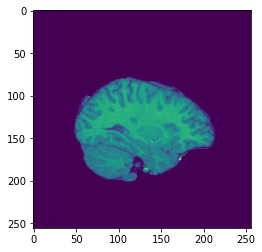

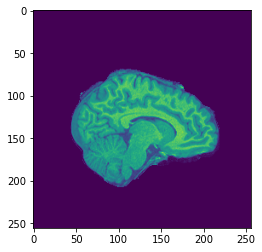

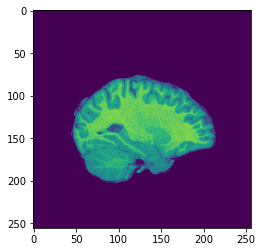

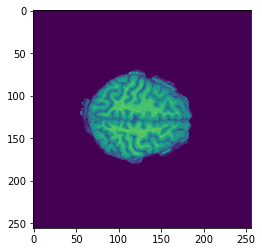

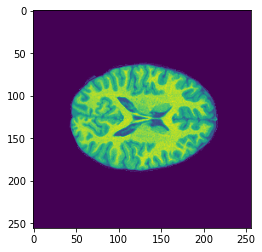

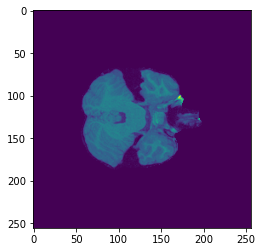

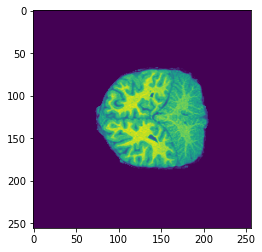

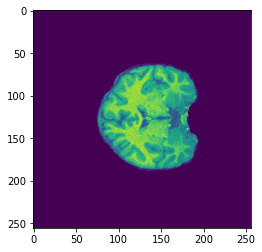

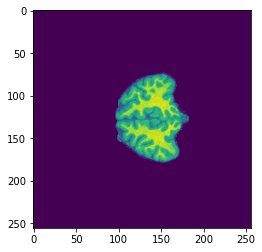

In [64]:
# Load the masked brain image
nibImg = nibabel.load(FS_folder+"mri/norm.mgz")
img = nibImg.get_fdata()

# # What volumes do we want? 
# # Third dim: 0 is back of head? max is front of head? AP view
# # Second dim: coronal, 0 is top and max is bottom of skull
# # First dim: sagittal? LR

# Goal: identify volume of brain that's non-zero
# Get the upper and lower bounds of brain in each dimension
dim0Lims, dim1Lims = np.where(img.any(axis=2))
_, dim2Lims = np.where(img.any(axis=1))

# Get the min and max of each dimension
dim0MinBrain = sorted(set(dim0Lims))[0]
dim0MaxBrain = sorted(set(dim0Lims))[-1]
dim1MinBrain = sorted(set(dim1Lims))[0]
dim1MaxBrain = sorted(set(dim1Lims))[-1]
dim2MinBrain = sorted(set(dim2Lims))[0]
dim2MaxBrain = sorted(set(dim2Lims))[-1]

def selectSliceIndices(brainMin, brainMax):
    # Get the slices for each dimension
    slice1 = int((brainMax - brainMin)/4 + brainMin + random.randint(-12, 12))
    slice2 = int((brainMax - brainMin)/2 + brainMin + random.randint(-12, 12))
    slice3 = int((brainMax - brainMin)*3/4 + brainMin + random.randint(-12, 12))
    
    return [slice1, slice2, slice3]

dim0Slices = selectSliceIndices(dim0MinBrain, dim0MaxBrain)
plt.figure()
plt.imshow(img[dim0Slices[0], :, :])
plt.figure()
plt.imshow(img[dim0Slices[1], :, :])
plt.figure()
plt.imshow(img[dim0Slices[2], :, :])

dim1Slices = selectSliceIndices(dim1MinBrain, dim1MaxBrain)
plt.figure()
plt.imshow(img[:, dim1Slices[0], :])
plt.figure()
plt.imshow(img[:, dim1Slices[1], :])
plt.figure()
plt.imshow(img[:, dim1Slices[2], :])

dim2Slices = selectSliceIndices(dim2MinBrain, dim2MaxBrain)
plt.figure()
plt.imshow(img[:, :, dim2Slices[0]])
plt.figure()
plt.imshow(img[:, :, dim2Slices[1]])
plt.figure()
plt.imshow(img[:, :, dim2Slices[2]])



In [18]:
##################################################################################################################
#
#   This script uses freeview to make screenshots of a freesurfer segmentation.
#   These screenshots are then combined to a movie, for easy diagnosis of 
#   FreeSurfer segmentation problems. I have chosen for sagittal orientation, 
#   because this allows one to see whether the sagittal sinus is misclassified as V1 gray matter. 
# 
##################################################################################################################

freeview_command = 'freeview -cmd {cmd} '
cmd_txt = """ -v {anatomy}:grayscale=10,100 -f {lh_wm}:color=red:edgecolor=red -f {rh_wm}:color=red:edgecolor=red -f {lh_pial}:color=white:edgecolor=white -f {rh_pial}:color=white:edgecolor=white
 -viewport sagittal
 """  

# it's also possible to load an EPI dataset, but you'll need a registration file also. The following string has to be appended to the cmd_txt
# -v {EPI}:colormap=jet:heatscale=20,200,500:reg={reg_filename}:opacity=0.65

# and we can also add labels, if we're interested in surface ROIs
# -l {lhV1label}:color=yellow -l {rhV1label}:color=yellow


# To step through the sagittal slices this is added for every slice. 
slice_addition = ' -slice {xpos} 127 127 \n -ss {opfn} \n  '  # Might need to change this line

# experiment = 'pRF_norm'  # 'DSC_3018028.02_957' 'DSC_3018028.04_752'
# freesurfer_subject_dir = os.environ['SUBJECTS_DIR']

subject_lists = range(6)
slices = range(90, 240)  # the slices in the anatomy to show. don't want to show a bunch of nothingness outside of the brain.


# for sji in subject_lists:  # list of subject indices
#     # this subject should be in the freesurfer subjects directory FS_folder
#     subject = 'sub-' + str(sji).zfill(3)
subject = "sub-HM9BLERT0"
#     FS_folder = os.path.join(freesurfer_subject_dir, subject)

    # here, another example of an experiment, in which there were EPIs and ROIs to also show
    # not necessary now. 
    #     EPI_glob = os.path.join(
    #         funcfolder, f'*.nii')
    #     EPI = glob.glob(EPI_glob)[0]
    #     print('EPI i: ' + EPI)
    #     reg_filename = os.path.join(
    #         funcfolder, egister.dat')
    # labels are in the FS directory
    #     # lhV1label = os.path.join(FS_folder, 'label', 'lh.V1.label')
    #     # rhV1label = os.path.join(FS_folder, 'label', 'rh.V1.label')

target_directory = os.path.join(FS_folder, 'movie')
#     os.makedirs(target_directory, exist_ok=True)

#     cmd_file = os.path.join(target_directory, 'cmd.txt')

sj_cmd = cmd_txt.format(
    anatomy=os.path.join(FS_folder, 'mri', 'T1.mgz'),
    lh_wm=os.path.join(FS_folder, 'surf', 'lh.white'),
    lh_pial=os.path.join(FS_folder, 'surf', 'lh.pial'),
    rh_wm=os.path.join(FS_folder, 'surf', 'rh.white'),
    rh_pial=os.path.join(FS_folder, 'surf', 'rh.pial'),
    subject=subject
)

for sag_slice in slices:

    sj_cmd += slice_addition.format(
        xpos=sag_slice,
        opfn=os.path.join(target_directory, str(
            sag_slice).zfill(3) + '.png')
    )

sj_cmd += ' -quit \n '

print(sj_cmd)

#     with open(cmd_file, 'w') as f:
#         f.write(sj_cmd)

#     sb.call(freeview_command.format(cmd=cmd_file), shell=True)

# calling this in a separate for loop for efficiency (this can be done headlessly, the freesurfer stuff cannot)
# for sji in subject_lists:
    # subject = 'sub-' + str(sji).zfill(3)
    # target_directory = f'freesurfer_subject_dir/{subject}/movie'

#     convert_command = f'ffmpeg -framerate 5 -pattern_type glob -i "{target_directory}/*.png" -b:v 2M -c:v mpeg4 {target_directory}/{subject}.mp4'
#     sb.call(convert_command, shell=True)

 -v /Users/youngjm/Data/clip/images/derivatives/mpr_fs_reconall_6.0.0/sub-HM9BLERT0/ses-0427age05903/anat/sub-HM9BLERT0_ses-0427age05903_acq-MprPrimary3p0UnknownContrastFromScanner35008_run-01_T1w/mri/T1.mgz:grayscale=10,100 -f /Users/youngjm/Data/clip/images/derivatives/mpr_fs_reconall_6.0.0/sub-HM9BLERT0/ses-0427age05903/anat/sub-HM9BLERT0_ses-0427age05903_acq-MprPrimary3p0UnknownContrastFromScanner35008_run-01_T1w/surf/lh.white:color=red:edgecolor=red -f /Users/youngjm/Data/clip/images/derivatives/mpr_fs_reconall_6.0.0/sub-HM9BLERT0/ses-0427age05903/anat/sub-HM9BLERT0_ses-0427age05903_acq-MprPrimary3p0UnknownContrastFromScanner35008_run-01_T1w/surf/rh.white:color=red:edgecolor=red -f /Users/youngjm/Data/clip/images/derivatives/mpr_fs_reconall_6.0.0/sub-HM9BLERT0/ses-0427age05903/anat/sub-HM9BLERT0_ses-0427age05903_acq-MprPrimary3p0UnknownContrastFromScanner35008_run-01_T1w/surf/lh.pial:color=white:edgecolor=white -f /Users/youngjm/Data/clip/images/derivatives/mpr_fs_reconall_6.0.0/s

In [ ]:
# For subject in the list of subjects
